# 依赖导入

In [44]:
from message_handle import build_conversation, apply_sft_template
from image_handle import load_pil_images, BasicImageTransform
from token_handle import text_encode
from transformers import AutoTokenizer
from PIL import ImageOps
import math
import torch

# 参数定义

In [41]:
prompt="<image>\nExtract the text in the image."     # 用户输入的Prompt
image_file = 'tengwangge.png'               # 图片文件
base_size = 512                             # TODO
image_size = 512                            # TODO
crop_mode = False                            # 是否使用裁减模式
model_path = "/home/guoteng/code/DeepSeek-OCR-Research/model_file"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)

patch_size = 16                             # 每个 patch 的像素大小
downsample_ratio = 4                        # 下采样比例

image_transform=BasicImageTransform(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), normalize=True)

# 二 构建对话结构

处理prompt

In [11]:
conversation = build_conversation(prompt, image_file)
prompt = apply_sft_template(conversation, sft_format='plain', system_prompt='')
prompt

'<image>\nExtract the text in the image.'

# 三 图像加载

加载图像

In [15]:
images = load_pil_images(conversation)
len(images)

1

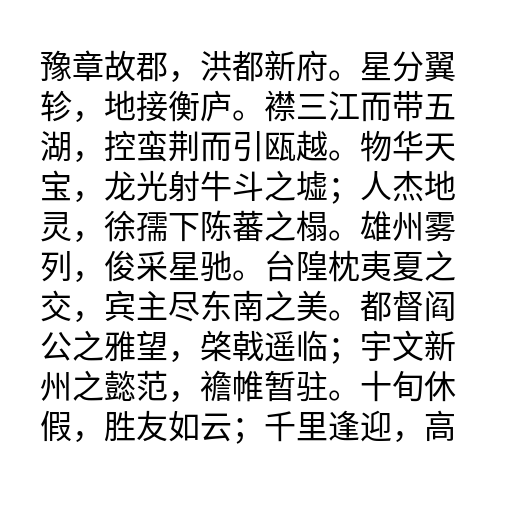

In [20]:
image_first = images[0]
image_first

计算第一张图像的宽高比例

In [16]:
image_draw = images[0].copy()
w, h = image_draw.size
ratio = 1 - ((max(w, h) - min(w, h)) / (max(w, h)))
ratio

1.0

## 3.N 扩展

### 3.N.1 resize

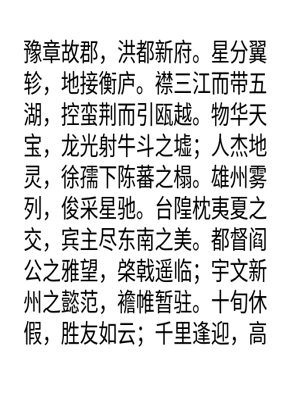

In [42]:
image_first_resize = image_first.resize((300, 400))
image_first_resize

### 3.N.2 pad

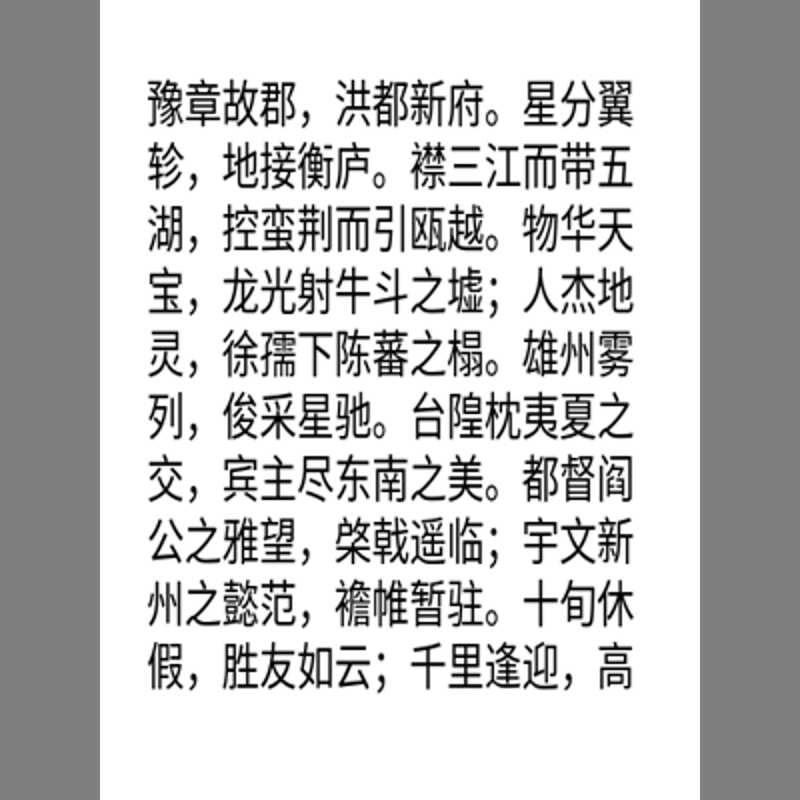

In [43]:
image_first_pad = ImageOps.pad(image_first_resize, (800, 800), color=tuple([int(0.5*255), int(0.5*255), int(0.5*255)]))
image_first_pad

图片转张量

In [45]:
image_tensor = image_transform(image_first_pad).to(torch.bfloat16)

In [47]:
image_tensor.shape

torch.Size([3, 800, 800])

# 四 构建模型输入

对prompt中图像占位进行处理

In [ ]:
image_token = '<image>'
image_token_id = 128815
text_splits = prompt.split(image_token)
text_splits

循环处理每张图片和它之前的文本

In [ ]:
tokenized_str = []
images_seq_mask = []
images_list = []
images_spatial_crop = []    # 图像裁剪数量
image_transform=BasicImageTransform(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5), normalize=True)
valid_img_tokens = 0

for text_sep, image in zip(text_splits, images):
    tokenized_sep = text_encode(tokenizer, text_sep, bos=False, eos=False)
    tokenized_str += tokenized_sep
    images_seq_mask += [False] * len(tokenized_sep)

    if crop_mode:
        print("Error, Do not support crop mode")
    else:
        """process the global view"""
        # 1. 如果image_size <= 640, 直接resize
        if image_size <= 640:
            print('directly resize')
            image = image.resize((image_size, image_size))

        # 2. 对图像进行填充，保持原始宽高比
        global_view = ImageOps.pad(image, (image_size, image_size),
                                        color=tuple(int(x * 255) for x in image_transform.mean))
        # 3. 将图像转换为Tensor
        images_list.append(image_transform(global_view).to(torch.bfloat16))

        # 4. 根据base_size设置有效tokens数量
        # 对于较小的尺寸使用固定值，而对于较大的尺寸根据 ratio 进行调整
        if base_size == 1024:
            valid_img_tokens += int(256 * ratio)
        elif base_size == 1280:
            valid_img_tokens += int(400 * ratio)
        elif base_size == 640:
            valid_img_tokens += int(100 * 1)
        elif base_size == 512:
            valid_img_tokens += int(64 * 1)
        
        # 由于未使用裁剪模式，所以宽度和高度的裁剪数量都设为1
        width_crop_num, height_crop_num = 1, 1
        images_spatial_crop.append([width_crop_num, height_crop_num])

        """add image tokens"""
        num_queries = math.ceil((image_size // patch_size) / downsample_ratio)
        tokenized_image = ([image_token_id] * num_queries + [image_token_id]) * num_queries
        tokenized_image += [image_token_id]
        tokenized_str += tokenized_image
        images_seq_mask += [True] * len(tokenized_image)

处理最后一个文本段

In [ ]:
"""process the last text split"""
tokenized_sep = text_encode(tokenizer, text_splits[-1], bos=False, eos=False)
tokenized_str += tokenized_sep
images_seq_mask += [False] * len(tokenized_sep)

添加bos token

In [ ]:
"""add the bos tokens"""
bos_id = 0
tokenized_str = [bos_id] + tokenized_str 
images_seq_mask = [False] + images_seq_mask

将输入转换为张量

In [ ]:
# 将token list 转换为张量
input_ids = torch.LongTensor(tokenized_str)
# 图像掩码，为True的位置是图像token的位置
images_seq_mask = torch.tensor(images_seq_mask, dtype=torch.bool)